# skeletracks: automatic separation of overlapping fission tracks in apatite and muscovite using image processing

## Alexandre Fioravante de Siqueira<sup>1,2</sup>, Wagner Massayuki Nakasuga<sup>1</sup>, Sandro Guedes de Oliveira<sup>1</sup>

<sup>1</sup> _Departamento de Raios Cósmicos e Cronologia, IFGW, University of Campinas, Brazil_

<sup>2</sup> _Institut für Geologie, TU Bergakademie Freiberg, Germany_

```
Copyright (C) 2018 Alexandre Fioravante de Siqueira

This file is part of 'skeletracks: automatic separation of overlapping
fission tracks in apatite and muscovite using image processing -
Supplementary Material'.

'skeletracks: automatic separation of overlapping fission tracks
in apatite and muscovite using image processing - Supplementary Material'
is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the
Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

'skeletracks: automatic separation of overlapping fission tracks
in apatite and muscovite using image processing - Supplementary Material'
is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with 'Segmentation of nearly isotropic overlapped tracks in
photomicrographs using successive erosions as watershed markers -
Supplementary Material'.  If not, see <http://www.gnu.org/licenses/>.
```

## Reproducing this paper and using the supplementary code: a how-to

Thank you for downloading these files. Before using this material, please download this file: <https://drive.google.com/open?id=1sQgTMK6_curfAWV3pw9ZIHaCUmjCPQwo>. After downloading, please unzip the file and place the contents in the folder containing all Supplementary Code.

### Installing Python

* If you do not have Python and the necessary modules installed on your PC, please install Anaconda before using this how-to: <https://www.anaconda.com/download/>. Download the suitable package according to your system, and install it following the page instructions. We use Python 3 for implementing and running this code.

### Importing the necessary modules

* This code is based on several Python modules. We need to import them before their use.

In [7]:
from glob import glob
from itertools import combinations, permutations, product
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from scipy.ndimage.morphology import binary_fill_holes
from scipy.stats import norm
from skimage.color import gray2rgb
from skimage.draw import line
from skimage.exposure import rescale_intensity
from skimage.graph import route_through_array
from skimage import io
from skimage.util import img_as_float, img_as_ubyte
from skimage.filters import threshold_otsu, threshold_yen, threshold_li, threshold_isodata
from skimage.measure import regionprops, label, compare_ssim
from skimage.morphology import remove_small_objects, skeletonize, skeletonize_3d
from skimage.restoration import denoise_tv_chambolle
from skimage.segmentation import clear_border

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import os
import statistics as stats
import warnings

* Now we import the functions presented in this study. They are inside the file `desiqueira2018.py`; please ensure that you are executing this how-to in the same folder as these functions, or the following command will return an error.

In [8]:
import desiqueira2018 as ds

### Some settings

* Here we establish a default font size, modify the resulting plots, ask to Matplotlib draw them on this how-to (and not on a separate window), and disable all warnings that could be generated. Since we will work with a large number of images, this is useful to avoid the several warnings that would appear.

In [9]:
default_fontsize = 15

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']
plt.rcParams['axes.titlesize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['legend.fontsize'] = 1.5*plt.rcParams['font.size']
plt.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
plt.rcParams['ytick.labelsize'] = plt.rcParams['font.size']

%matplotlib inline
warnings.filterwarnings('ignore')

### Calling support functions

* This how-to depends on some functions to generate results and to help plotting data. Here we call all these functions.

In [10]:
from supmat_support import *

### Defining helping constants

* Here we define some helping constants: `WEIGHT_FILTER`, the weight for the TV Chambolle function, and `MIN_SIZE`, the minimum area for considering an interest region as a track.

In [12]:
WEIGHT_FILTER = 0.05
MIN_SIZE = 25

## Obtaining the image collection

* First, we use `ImageCollection()` to read all images in the folder `orig_figures`. After that, we print the number of images in this dataset.

In [13]:
fnames_mica = sorted(glob('orig_figures/*mica*.tif'))
imgset_mica = [io.imread(fname, as_gray=True) for fname in fnames_mica]

fnames_apte = sorted(glob('orig_figures/*apatite*.tif'))
imgset_apte = [io.imread(fname, as_gray=True) for fname in fnames_apte]

print('Number of images on dataset: ', len(imgset_mica) + len(imgset_apte))

Number of images on dataset:  79


## Filtering and binarizing images

* Here we binarize all images using different algorithms: Otsu, Yen, Li, ISODATA, triangle, MLSS.

* We also perform some cleaning actions:
    * `remove_small_objects()`, in its default settings, removes objects with an area smaller than `MIN_SIZE` pixels.
    * `binary_fill_holes()` fills holes contained in objects.
    * `clear_rd_border()` removes objects touching the lower and right borders. These objects could not be identified with precision.

* After that, we present the results of these actions on the first images from the set.

In [15]:
def binarize_imageset(image_set):
    
    imgbin_otsu, imgbin_yen, imgbin_li, imgbin_iso = [[] for _ in range(4)]

    for image in image_set:
        # Filtering.
        image = denoise_tv_chambolle(image, weight=WEIGHT_FILTER)
        # Binarizing.
        imgbin_otsu.append(_process_image(image, threshold='otsu'))  # Otsu
        imgbin_yen.append(_process_image(image, threshold='yen'))  # Yen
        imgbin_li.append(_process_image(image, threshold='li'))  # Li
        imgbin_iso.append(_process_image(image, threshold='isodata'))  # ISODATA

    return imgbin_otsu, imgbin_yen, imgbin_li, imgbin_iso


def _process_image(image, threshold='isodata', weight=WEIGHT_FILTER, min_size=MIN_SIZE):
    """
    """

    if threshold is not None:
        func_thresh = {'otsu': threshold_otsu,
                       'yen': threshold_yen,
                       'li': threshold_li,
                       'isodata': threshold_isodata,
                       }.get(threshold, threshold_isodata)
        thresh = func_thresh(image)
        image = image < thresh

    img_bin = ds.clear_rd_border(remove_small_objects(
                                     binary_fill_holes(image),
                                         min_size=min_size))

    return img_bin

* Binarizing images.

In [16]:
binotsu_mica, binyen_mica, binli_mica, biniso_mica = binarize_imageset(imgset_mica)
binotsu_apte, binyen_apte, binli_apte, biniso_apte = binarize_imageset(imgset_apte)

# reading and processing the binary MLSS images.
binmlss_mica, binmlss_apte = [], []

for fname in fnames_mica:
    mlss_fname = 'auto_count/mlss/' + fname.split('/')[1][:-4] + '.csv'
    binmlss_mica.append(_process_image(np.asarray(pd.read_csv(mlss_fname), dtype='bool'), threshold=None))

for fname in fnames_apte:
    mlss_fname = 'auto_count/mlss/' + fname.split('/')[1][:-4] + '.csv'
    binmlss_apte.append(_process_image(np.asarray(pd.read_csv(mlss_fname), dtype='bool'), threshold=None))

## Exemplifying the binarizations used

* Here we present a sample binarized using the algorithms proposed. First, we use a muscovite image:

Text(0.5, 0, 'MLSS')

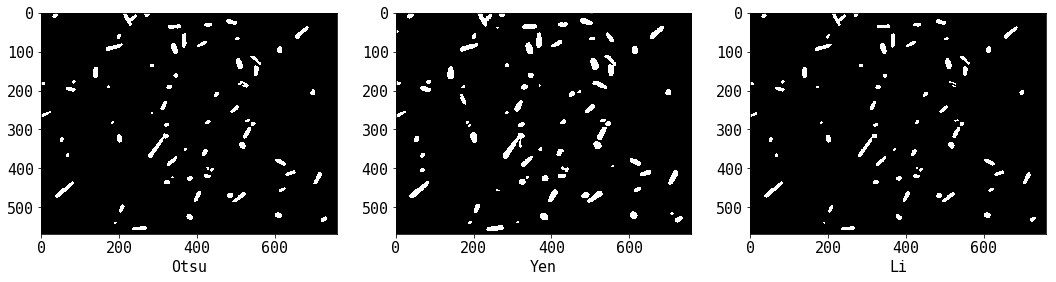

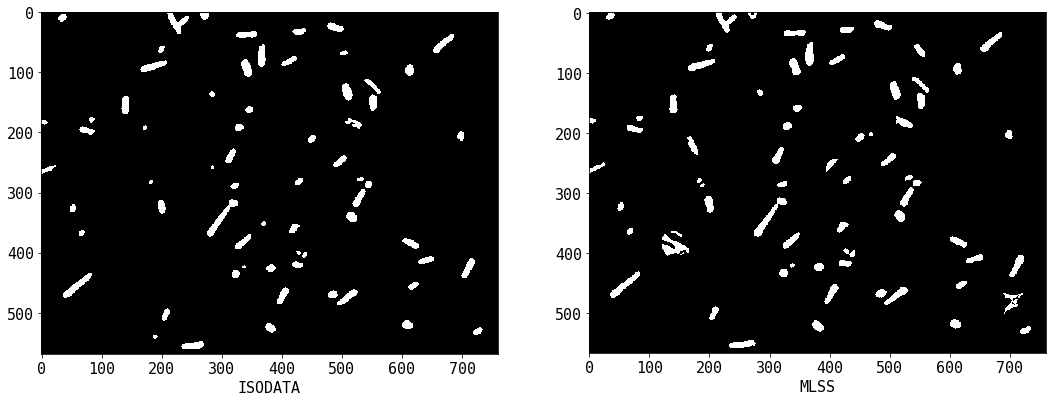

In [17]:
fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=3)

SAMPLE = 4

# Otsu
ax[0].imshow(binotsu_mica[SAMPLE], cmap='gray')
ax[0].set_xlabel('Otsu')

# Yen
ax[1].imshow(binyen_mica[SAMPLE], cmap='gray')
ax[1].set_xlabel('Yen')

# Li
ax[2].imshow(binli_mica[SAMPLE], cmap='gray')
ax[2].set_xlabel('Li')

fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=2)

# ISODATA
ax[0].imshow(biniso_mica[SAMPLE], cmap='gray')
ax[0].set_xlabel('ISODATA')

# MLSS
ax[1].imshow(binmlss_mica[SAMPLE], cmap='gray')
ax[1].set_xlabel('MLSS')

* Now, we show the results on an apatite image.

Text(0.5, 0, 'MLSS')

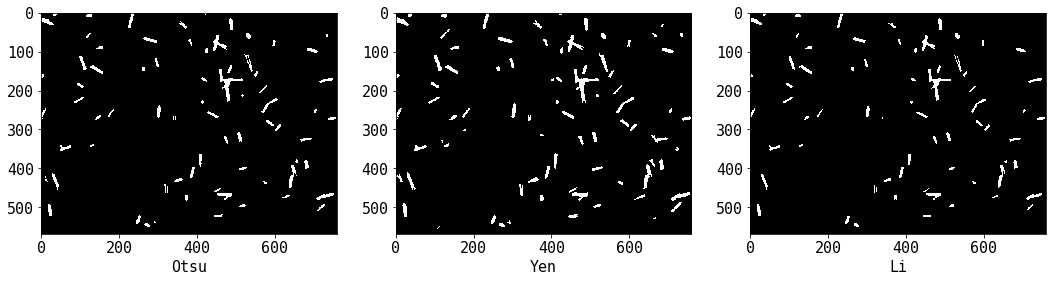

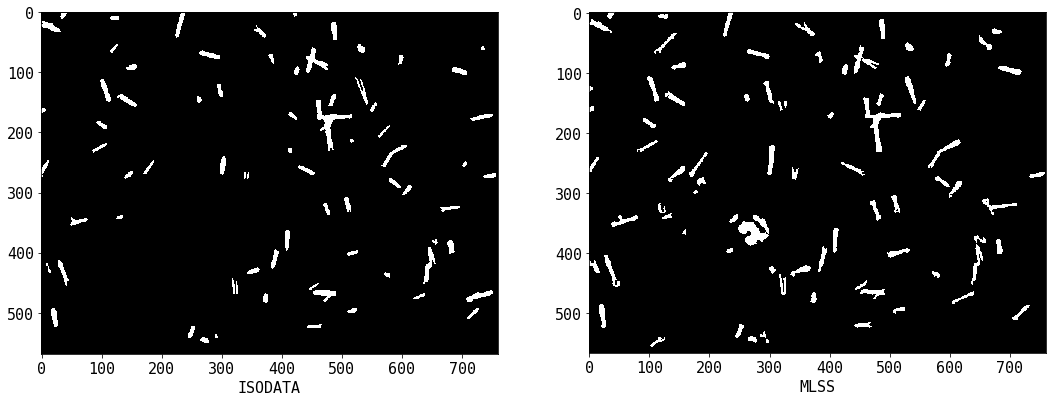

In [21]:
fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=3)

# Otsu
ax[0].imshow(binotsu_apte[SAMPLE], cmap='gray')
ax[0].set_xlabel('Otsu')

# Yen
ax[1].imshow(binyen_apte[SAMPLE], cmap='gray')
ax[1].set_xlabel('Yen')

# Li
ax[2].imshow(binli_apte[SAMPLE], cmap='gray')
ax[2].set_xlabel('Li')

fig, ax = plt.subplots(figsize=(18, 9), nrows=1, ncols=2)

# ISODATA
ax[0].imshow(biniso_apte[SAMPLE], cmap='gray')
ax[0].set_xlabel('ISODATA')

# MLSS
ax[1].imshow(binmlss_apte[SAMPLE], cmap='gray')
ax[1].set_xlabel('MLSS')

## Pre-processing images

* Here we use the function `regions_and_skel()`, which separates the interest regions, skeletonizes them, and returns the results. First, the muscovite samples...

In [8]:
regotsu_mica = ds.regions_and_skel(binotsu_mica)
regyen_mica = ds.regions_and_skel(binyen_mica)
regli_mica = ds.regions_and_skel(binli_mica)
regiso_mica = ds.regions_and_skel(biniso_mica)
regmlss_mica = ds.regions_and_skel(binmlss_mica)

/home/jaguar/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


* ... and now, the apatite samples.

In [9]:
regotsu_apte = ds.regions_and_skel(binotsu_apte)
regyen_apte = ds.regions_and_skel(binyen_apte)
regli_apte = ds.regions_and_skel(binli_apte)
regiso_apte = ds.regions_and_skel(biniso_apte)
regmlss_apte = ds.regions_and_skel(binmlss_apte)

/home/jaguar/anaconda3/lib/python3.7/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


## Automatic counting

* Here we have functions for automatically classifying and counting tracks.

In [10]:
def autocount_tracks():
    # Otsu
    print('* counting tracks in Otsu binary images.')
    ds.count_and_save(regotsu_mica,
                      filename='auto_count/autootsu_mica.csv',
                      show_exectime=False)
    ds.count_and_save(regotsu_apte,
                      filename='auto_count/autootsu_apatite.csv',
                      show_exectime=False)

    # Yen
    print('* counting tracks in Yen binary images.')
    ds.count_and_save(regyen_mica,
                      filename='auto_count/autoyen_mica.csv',
                      show_exectime=False)
    ds.count_and_save(regyen_apte,
                      filename='auto_count/autoyen_apatite.csv',
                      show_exectime=False)

    # Li
    print('* counting tracks in Li binary images.')
    ds.count_and_save(regli_mica,
                      filename='auto_count/autoli_mica.csv',
                      show_exectime=False)
    ds.count_and_save(regli_apte,
                      filename='auto_count/autoli_apatite.csv',
                      show_exectime=False)

    # ISODATA
    print('* counting tracks in ISODATA binary images.')
    ds.count_and_save(regiso_mica,
                      filename='auto_count/autoiso_mica.csv',
                      show_exectime=False)
    ds.count_and_save(regiso_apte,
                      filename='auto_count/autoiso_apatite.csv',
                      show_exectime=False)

    # MLSS
    print('* counting tracks in MLSS binary images.')
    ds.count_and_save(regmlss_mica,
                      filename='auto_count/automlss_mica.csv',
                      show_exectime=False)
    ds.count_and_save(regmlss_apte,
                      filename='auto_count/automlss_apatite.csv',
                      show_exectime=False)

    return None

* Please uncomment (remove the `#` in) the line `autocount_tracks` below to generate the results. If you do not want to calculate them, they are already stored in the folder `auto_count`.

In [11]:
#autocount_tracks()

* Now we read the automatic counting results. First, for muscovite...

In [4]:
autootsu_mica = np.loadtxt('auto_count/autootsu_mica.csv', delimiter=',')
autoyen_mica = np.loadtxt('auto_count/autoyen_mica.csv', delimiter=',')
autoli_mica = np.loadtxt('auto_count/autoli_mica.csv', delimiter=',')
autoiso_mica = np.loadtxt('auto_count/autoiso_mica.csv', delimiter=',')
automlss_mica = np.loadtxt('auto_count/automlss_mica.csv', delimiter=',')

* ... and now, for the apatite images.

In [5]:
autootsu_apte = np.loadtxt('auto_count/autootsu_apatite.csv', delimiter=',')
autoyen_apte = np.loadtxt('auto_count/autoyen_apatite.csv', delimiter=',')
autoli_apte = np.loadtxt('auto_count/autoli_apatite.csv', delimiter=',')
autoiso_apte = np.loadtxt('auto_count/autoiso_apatite.csv', delimiter=',')
automlss_apte = np.loadtxt('auto_count/automlss_apatite.csv', delimiter=',')

## Manual counting

* Here we read the manual counting results, obtained by W.M.N.

In [6]:
manual_mica = ds.manual_counting(mineral='mica')
manual_apte = ds.manual_counting(mineral='apatite')

In [15]:
def ratio_manauto(manual, auto):
    """
    """

    ratio = np.asarray(auto) / np.asarray(manual)

    print('\n* Manual mean: ', str(manual.mean()), ' +/- ', str(manual.std()),
          '\n* Auto mean: ', str(auto.mean()), ' +/- ', str(auto.std()),
          '\n* Ratio mean: ', str(ratio.mean()), ' +/- ', str(ratio.std()))

    return None


In [16]:
print('* Otsu:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autootsu_mica))
ratio_manauto(np.asarray(manual_apte), np.asarray(autootsu_apte))

* Otsu:

* Manual mean:  57.91836734693877  +/-  8.358880734306618 
* Auto mean:  51.57142857142857  +/-  6.743099269260541 
* Ratio mean:  0.895310830228164  +/-  0.0770651298446779

* Manual mean:  103.8  +/-  11.914696806885184 
* Auto mean:  97.63333333333334  +/-  9.403840822888393 
* Ratio mean:  0.9449396897798772  +/-  0.06892487895953622


In [17]:
np.mean(automlss_mica)/np.mean(automlss_apte)

0.766281626459385

In [18]:
print('* Yen:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autoyen_mica))
ratio_manauto(np.asarray(manual_apte), np.asarray(autoyen_apte))

* Yen:

* Manual mean:  57.91836734693877  +/-  8.358880734306618 
* Auto mean:  56.06122448979592  +/-  7.296653309636748 
* Ratio mean:  0.9727549363231983  +/-  0.07528057530256266

* Manual mean:  103.8  +/-  11.914696806885184 
* Auto mean:  102.56666666666666  +/-  9.496256572402038 
* Ratio mean:  0.9931724877812854  +/-  0.07508684032415679


In [19]:
print('* Li:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autoli_mica))
ratio_manauto(np.asarray(manual_apte), np.asarray(autoli_apte))

* Li:

* Manual mean:  57.91836734693877  +/-  8.358880734306618 
* Auto mean:  51.04081632653061  +/-  6.779197423069927 
* Ratio mean:  0.8847294471639352  +/-  0.06321877927917537

* Manual mean:  103.8  +/-  11.914696806885184 
* Auto mean:  93.06666666666666  +/-  16.28073162429202 
* Ratio mean:  0.8993404946068109  +/-  0.13417009004759695


In [20]:
print('* ISODATA:')
ratio_manauto(np.asarray(manual_mica), np.asarray(autoiso_mica))
ratio_manauto(np.asarray(manual_apte), np.asarray(autoiso_apte))

* ISODATA:

* Manual mean:  57.91836734693877  +/-  8.358880734306618 
* Auto mean:  51.69387755102041  +/-  6.794968371426001 
* Ratio mean:  0.8972577042158544  +/-  0.07632481251306575

* Manual mean:  103.8  +/-  11.914696806885184 
* Auto mean:  97.73333333333333  +/-  9.6122606891176 
* Ratio mean:  0.9458803944910739  +/-  0.07100298508464394


In [21]:
print('* MLSS:')
ratio_manauto(np.asarray(manual_mica), np.asarray(automlss_mica))
ratio_manauto(np.asarray(manual_apte), np.asarray(automlss_apte))

* MLSS:

* Manual mean:  57.91836734693877  +/-  8.358880734306618 
* Auto mean:  84.16326530612245  +/-  12.917867611316126 
* Ratio mean:  1.4857286695005545  +/-  0.32038489517644325

* Manual mean:  103.8  +/-  11.914696806885184 
* Auto mean:  109.83333333333333  +/-  10.82307206336948 
* Ratio mean:  1.069987415663724  +/-  0.1472787849816943


In [22]:
def plot_tracks(image, trk_averages, trk_points):
    '''
    '''

    if trk_averages is None:
        print('No averages (possibly only one track).')
        return None

    image_rgb = gray2rgb(image)

    # preparing the plot window.
    fig, ax = plt.subplots(nrows=1, ncols=1)

    for trk_idx, trk_pt in enumerate(trk_points):

        # calculating route and distances.
        route, _ = route_through_array(~image, trk_pt[0], trk_pt[1])
        distances, _, _ = ds.track_parameters(trk_pt[0], trk_pt[1], route)

        # generating minimal distance line.
        rows, cols = line(trk_pt[0][0], trk_pt[0][1],
                          trk_pt[1][0], trk_pt[1][1])
        image_rgb[rows, cols] = [0, 255, 0]

        # plotting minimal distance and route.
        ax.imshow(image_rgb, cmap='gray')

        for rt_pt in route:
            ax.scatter(rt_pt[1], rt_pt[0], c='b')

        #plotting extreme points.
        for pt in trk_pt:
            ax.scatter(pt[1], pt[0], c='g')

    return None

## Calibration and conversion: from $px$ to $cm^2$

In [ ]:
poly_coef = ds.calibration()

fit = np.arange(0, 760)
fit_mm = poly_coef[0] * fit + poly_coef[1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(x=calib['px'],
           y=calib['mm'],
           c='k')
ax.plot(fit, fit_mm, c='m')
ax.set_xlabel('Length (px)')
ax.set_ylabel('Length (mm)')

In [ ]:
def px_to_mm(poly_coef, length=760):

    ang_coef, lin_coef = poly_coef
    mm = length*ang_coef + lin_coef

    return mm

In [ ]:
px_to_mm(poly_coef, length=4.2) * 1e3

In [ ]:
ds.px_to_cm2(poly_coef)

In [ ]:
def gqr_calc(mica, apatite):
    """
    """

    gqr = np.mean(mica/px_to_cm2()) / np.mean(apatite/px_to_cm2())

    return gqr


def track_stats(ext_detec, int_surf):
    """
    """

    # ed: external detector
    rho_ed = np.mean(ext_detec) / px_to_cm2()
    n_ed = np.sum(ext_detec)

    sigma_n_ed = np.sqrt(n_ed)
    relat_ed = 1/np.sqrt(n_ed)  # incerteza relativa
    sigma_rho_ed = relat_ed * rho_ed

    # is: internal surface
    rho_is = np.mean(int_surf) / px_to_cm2()
    n_is = np.sum(int_surf)

    sigma_n_is = np.sqrt(n_is)
    relat_is = 1/np.sqrt(n_is)  # incerteza relativa
    sigma_rho_is = relat_is * rho_is

    # GQR
    gqr = rho_ed / rho_is
    sigma_gqr = np.sqrt((relat_is ** 2) + (relat_ed ** 2)) * gqr

    stats = ((n_ed, sigma_n_ed), (n_is, sigma_n_is),
             (rho_ed * 1e-6, sigma_rho_ed * 1e-6),
             (rho_is * 1e-6, sigma_rho_is * 1e-6),
             (gqr, sigma_gqr))

    return stats

## Obtaining track stats for each counting.

In [7]:
otsu_stats = ds.TrackStats(autootsu_mica, autootsu_apte)
yen_stats = ds.TrackStats(autoyen_mica, autoyen_apte)
li_stats = ds.TrackStats(autoli_mica, autoli_apte)
iso_stats = ds.TrackStats(autoiso_mica, autoiso_apte)
mlss_stats = ds.TrackStats(automlss_mica, automlss_apte)
manual_stats = ds.TrackStats(manual_mica, manual_apte)

In [8]:
otsu_stats.gqr

(0.5282153831146661, 0.01434121408405648)

In [9]:
yen_stats.gqr

(0.5465832741936554, 0.014347424339176483)

In [10]:
iso_stats.gqr

(0.5289278057744243, 0.014348017700564217)

In [11]:
li_stats.gqr

(0.5484328401847844, 0.015099405437989393)

In [12]:
mlss_stats.gqr

(0.766281626459385, 0.017904989066163734)

In [13]:
manual_stats.gqr

(0.5579804176005663, 0.0144805453864624)

In [43]:
print(otsu_stats.ext_dec.sum(),
      np.asarray(track_stats.n_extdec)/len(track_stats.ext_dec),
      otsu_stats.gqr)

2527.0 [51.57142857  1.02590357] (0.5282153831146661, 0.01434121408405648)


## Counting time of each algorithm

In [ ]:
count_time = pd.read_csv('counting_time.csv')

count_auto = [count_time[count_time['sample'] == 'mica']['otsu'],
              count_time[count_time['sample'] == 'mica']['yen'],
              count_time[count_time['sample'] == 'mica']['li'],
              count_time[count_time['sample'] == 'mica']['isodata'],
              count_time[count_time['sample'] == 'mica']['mlss']]

In [ ]:


    
for trk_idx, trk_pt in enumerate(trk_px):

    # calculating route and distances.
    route, _ = route_through_array(~img_aux, trk_pt[0], trk_pt[1])
    distances, _, _ = ds.track_parameters(trk_pt[0], trk_pt[1], route)

    # generating minimal distance line.
    rows, cols = line(trk_pt[0][0], trk_pt[0][1],
                      trk_pt[1][0], trk_pt[1][1])
    rgb_otsu[rows, cols] = [0, 255, 0]

    # plotting minimal distance and route.
    ax[1].imshow(rgb_otsu, cmap='gray')

    for rt_pt in route:
        ax[1].scatter(rt_pt[1], rt_pt[0], c='b')

    #plotting extreme points.
    for pt in trk_pt:
        ax[1].scatter(pt[1], pt[0], c='g')

ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[10].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[15].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[17].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))
x_min, y_min, x_max, y_max = props[25].bbox

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[0].set_xlabel('Original')

ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[1].yaxis.set_visible(False)
ax[1].set_xlabel('Otsu')

ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[2].yaxis.set_visible(False)
ax[2].set_xlabel('Yen')

ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[3].yaxis.set_visible(False)
ax[3].set_xlabel('Li')

ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[4].yaxis.set_visible(False)
ax[4].set_xlabel('ISODATA')

ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[5].yaxis.set_visible(False)
ax[5].set_xlabel('Triangle')

ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
ax[6].yaxis.set_visible(False)
ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))

for i in range(50, 75):
    x_min, y_min, x_max, y_max = props[i].bbox

    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

    ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[0].set_xlabel('Original')

    ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[1].yaxis.set_visible(False)
    ax[1].set_xlabel('Otsu')

    ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[2].yaxis.set_visible(False)
    ax[2].set_xlabel('Yen')

    ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[3].yaxis.set_visible(False)
    ax[3].set_xlabel('Li')

    ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[4].yaxis.set_visible(False)
    ax[4].set_xlabel('ISODATA')

    ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[5].yaxis.set_visible(False)
    ax[5].set_xlabel('Triangle')

    ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[6].yaxis.set_visible(False)
    ax[6].set_xlabel('MLSS')

In [ ]:
props = regionprops(label(imgbin_mlss[0]))

for i in [15, 10, 25, 72, 1, 17, 68, 55]:
    x_min, y_min, x_max, y_max = props[i].bbox

    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(24, 6))

    ax[0].imshow(image_set[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[0].set_xlabel('Original')

    ax[1].imshow(imgbin_otsu[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[1].yaxis.set_visible(False)
    ax[1].set_xlabel('Otsu')

    ax[2].imshow(imgbin_yen[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[2].yaxis.set_visible(False)
    ax[2].set_xlabel('Yen')

    ax[3].imshow(imgbin_li[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[3].yaxis.set_visible(False)
    ax[3].set_xlabel('Li')

    ax[4].imshow(imgbin_isodata[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[4].yaxis.set_visible(False)
    ax[4].set_xlabel('ISODATA')

    ax[5].imshow(imgbin_triangle[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[5].yaxis.set_visible(False)
    ax[5].set_xlabel('Triangle')

    ax[6].imshow(imgbin_mlss[0][x_min:x_max, y_min:y_max], cmap='gray')
    ax[6].yaxis.set_visible(False)
    ax[6].set_xlabel('MLSS')

In [31]:
import numpy as np


print('Otsu variance: ', np.var([0.68, 0.70, 0.75, 0.74]))

print('Yen variance: ', np.var([0.7, 0.69, 0.78, 0.71]))

print('Li variance: ', np.var([0.68, 0.71, 0.75, 0.76]))

print('ISODATA variance: ', np.var([0.68, 0.71, 0.75, 0.74]))

print('Triangle variance: ', np.var([0.71, 0.72, 0.8, 0.73]))

print('MLSS variance: ', np.var([0.74, 0.78, 0.77, 0.74]))

Otsu variance:  0.0008187499999999994
Yen variance:  0.0012500000000000022
Li variance:  0.0010249999999999994
ISODATA variance:  0.0007499999999999991
Triangle variance:  0.0012500000000000022
MLSS variance:  0.00031875000000000056


In [ ]:
image = imread('orig_figures/sample1_01.jpg', as_grey=True)

thresh = threshold_otsu(image)
imgbin_otsu = binary_fill_holes(
    remove_small_objects(image < thresh))

props = regionprops(label(imgbin_otsu))

img_skel = skeletonize_3d(imgbin_otsu)
rows, cols = np.where(img_skel != 0)
img_rgb = gray2rgb(img_as_ubyte(image))
img_rgb[rows, cols] = [255, 0, 255]

fig, ax = plt.subplots(figsize=(15, 10))

for prop in props:
    obj_info = []
    aux = skeletonize_3d(prop.image)
    trk_area, trk_px = ds.tracks_classify(aux)
    count_auto = ds.count_by_region(ds.regions_and_skel(prop.image))
    
    x_min, y_min, x_max, y_max = prop.bbox
    obj_info.append([prop.centroid[0],
                     prop.centroid[1],
                     str(count_auto[2][0][0])])
    for obj in obj_info:
        ax.text(obj[1], obj[0], obj[2], family='monospace', color='yellow', size='x-large', weight='bold')

    if trk_area is not None:

        for px in trk_px:
            route, _ = route_through_array(~aux, px[0], px[1])

            for rx in route:
                plt.scatter(y_min+rx[1], x_min+rx[0], s=20, c='b')

            for p in px:
                plt.scatter(y_min+p[1], x_min+p[0], s=20, c='g')

            rows, cols = line(x_min+px[0][0], y_min+px[0][1],
                              x_min+px[1][0], y_min+px[1][1])
            img_rgb[rows, cols] = [0, 255, 0]

plt.imshow(img_rgb, cmap='gray')

## Notes

### Saving counted images.

* The following code saves annotated results for each image, according to the binarization algorithms.

#### Otsu

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_otsu[idx], intensity_image=image)
    filename = 'res_figures/otsu/image' + str(idx+1) + '_otsu.eps'
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### Yen

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_yen[idx], intensity_image=image)
    filename = 'res_figures/yen/image' + str(idx+1) + '_yen.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### Li

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_li[idx], intensity_image=image)
    filename = 'res_figures/li/image' + str(idx+1) + '_li.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### ISODATA

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_isodata[idx], intensity_image=image)
    filename = 'res_figures/isodata/image' + str(idx+1) + '_isodata.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

#### MLSS

In [ ]:
for idx, image in enumerate(image_set):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax, count = ds.plot_and_count(imgbin_mlss[idx], intensity_image=image)
    filename = 'res_figures/mlss/image' + str(idx+1) + '_mlss.eps' 
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax, count = ds.plot_and_count(imgbin_otsu[0])

In [ ]:
plt.figure(figsize=(15, 10))
plt.imshow(imgbin_otsu[0])

In [ ]:
image = imread('test1.jpg', as_grey=True)

In [ ]:
thresh = threshold_otsu(image)
image_bin = thresh > image

In [ ]:
image_bin = binary_fill_holes(remove_small_objects(image_bin))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
ax, count = ds.plot_and_count(image_bin, intensity_image=image)

In [ ]:
count